In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

**PV production calculation**

Methodology based on this paper: https://www.researchgate.net/publication/331837767_The_energetic_implications_of_introducing_lithium-ion_batteries_into_distributed_photovoltaic_systems

Get local data from https://re.jrc.ec.europa.eu/pvg_tools/en/#HR
for years 2010-2016 to average yearly variability
Solar panels were assumed to be 46 inclined towards south to maximize yearly yield without the need for sophisticated mechanic installations.

Read data into dataframe

In [3]:
os.chdir('/home/MA')

In [4]:
meteo_data_hawaii = pd.read_csv('Data/Timeseries_Hawaii.csv')

Timezone to UTC: -10 hours

Convert time column to datetime format to facilitate data processing

In [5]:
meteo_data_hawaii['time'] = pd.to_datetime(meteo_data_hawaii['time'], format='%Y%m%d:%H%M')

Get rid of leap years

In [6]:
meteo_data_hawaii = meteo_data_hawaii[~((meteo_data_hawaii.time.dt.month == 2) & (meteo_data_hawaii.time.dt.day == 29))]

In [7]:
len(meteo_data_hawaii)/8760

6.0

Check date of maximum value

In [8]:
meteo_data_hawaii[meteo_data_hawaii['G(i)'] == meteo_data_hawaii['G(i)'].max()]

,time,G(i),H_sun,T2m,WS10m,Int
45575,2015-03-14 23:00:00,1090.08,65.72,21.51,8.91,0


This is the absolute amount of radiation incident on a solar cell in Zurich without accounting for the conversion efficiency. 
As expected, it occurs on the 22th of March, the date where the sun's angle is exactly perpendicular to the panel's orientation.

Calculate hourly averages over the defined period of years by grouping and taking the mean.

In [9]:
hourly_average=meteo_data_hawaii.groupby([meteo_data_hawaii["time"].dt.month, meteo_data_hawaii["time"].dt.day, meteo_data_hawaii["time"].dt.hour]).mean()

In [10]:
hourly_average.index.names = ["month", "day", "hour"]

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


In [11]:
shift = 10

In [12]:
temp = hourly_average.head(shift)

In [13]:
hourly_average = hourly_average.shift(-shift)

In [14]:
hourly_average.to_numpy()[-shift:]=temp

Define conversion efficiency

In [15]:
conv_eff = 0.17 # 2020 slide 7 on https://www.ise.fraunhofer.de/content/dam/ise/de/documents/publications/studies/Photovoltaics-Report.pdf

Calculate power production

In [16]:
hourly_average['Prod/m2'] = hourly_average['G(i)']*0.17/1000
hourly_average.head(24)

G(i)  H_sun        T2m     WS10m       Int   Prod/m2
month day hour                                                            
1     1   0       0.000000   0.00  23.461667  5.358333  0.000000  0.000000
          1       0.000000   0.00  23.415000  5.161667  0.000000  0.000000
          2       0.000000   0.00  23.371667  4.961667  0.000000  0.000000
          3       0.000000   0.00  23.291667  4.916667  0.000000  0.000000
          4       0.000000   0.00  23.213333  4.866667  0.000000  0.000000
          5       0.000000   0.00  23.141667  4.821667  0.000000  0.000000
          6       0.000000   0.00  23.138333  5.028333  0.000000  0.000000
          7       0.000000   0.00  23.135000  5.231667  0.000000  0.000000
          8     195.860000   9.68  23.131667  5.433333  0.000000  0.033296
          9     428.836667  21.38  23.050000  5.511667  0.000000  0.072902
          10    521.975000  31.75  22.968333  5.591667  0.166667  0.088736
          11    744.768333  39.97  22.886667  5.668333  0.000000  0.126611
          12    794.455000  44.84  23.030000  5.463333  0.000000  0.135057
          13    613.633333  45.25  23.175000  5.260000  0.000000  0.104318
          14    688.596667  41.20  23.326667  5.056667  0.000000  0.117061
          15    543.853333  33.46  23.293333  5.075000  0.000000  0.092455
          16    410.131667  23.38  23.256667  5.096667  0.000000  0.069722
          17    207.465000  11.87  23.223333  5.116667  0.000000  0.035269
          18      0.000000   0.00  23.303333  5.056667  0.000000  0.000000
          19      0.000000   0.00  23.380000  5.000000  0.000000  0.000000
          20      0.000000   0.00  23.460000  4.938333  0.000000  0.000000
          21      0.000000   0.00  23.461667  4.918333  0.000000  0.000000
          22      0.000000   0.00  23.465000  4.891667  0.000000  0.000000
          23      0.000000   0.00  23.475000  4.868333  0.000000  0.000000

In [17]:
PV_size = 6 #kW_p

In [18]:
size = 6*PV_size # m2 necessary for 6 kW_p
# https://www.energieheld.de/solaranlage/photovoltaik
# https://www.energieheld.ch/solaranlagen/photovoltaik#:~:text=Rechnen%20Sie%20im%20Durchschnitt%20etwa,dieser%20Gr%C3%B6sse%20installieren%20zu%20k%C3%B6nnen.

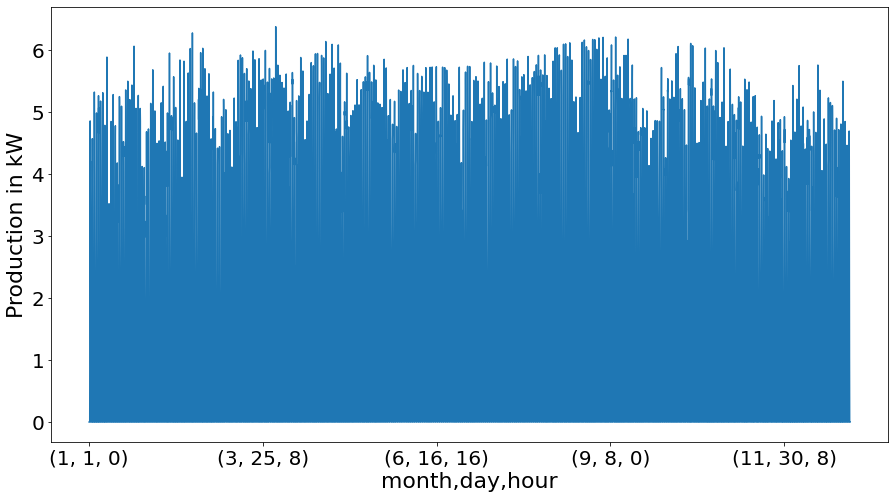

In [19]:
hourly_average['Prod'] = hourly_average['Prod/m2']*size
hourly_average['Prod'].plot(fontsize = 20, ylabel = 'Production in kW');

Calculate yearly production

In [20]:
yearly_PV_prod = hourly_average['Prod'].sum()

In [21]:
yearly_PV_prod

13293.327327000003

In [22]:
hourly_average['Prod'].to_pickle('Calculations/Hawaii/PV_production_Hawaii.pkl')